In [7]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(seed=42) 

In [8]:
raw_info = pd.read_csv(f"/ASD/ahsan_projects/braintypicality/dataset/IBIS_V06_CSF_All.csv", usecols=[
    "CandID","Age_at_visit_start","Project","Status","ASD_DX",
    "ASD_DX_group","group ID","Identifiers","Cohort","Risk"])
raw_info.head()

,CandID,Age_at_visit_start,Project,Status,ASD_DX,ASD_DX_group,group ID,Identifiers,Cohort,Risk
0,103430,25.0,IBIS1,Complete,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,STL0188,6 month recruit,HR
1,107524,25.0,IBIS1,Complete,YES (DSM_IV questions 4a/4b is Yes),ASD,2,STL0200,6 month recruit,HR
2,108372,24.0,IBIS2,Active,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,UNC1023,IBIS2 Low Risk,LR
3,113320,24.0,IBIS1,Active,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,PHI0207,Control,LR
4,114640,26.0,IBIS1,Active,NO (DSM_IV questions 4a/4b is no and not atypi...,TYPICAL,1,SEA0102,Control,LR


In [9]:
raw_info[["ASD_DX_group", "Risk"]].value_counts()

ASD_DX_group     Risk
TYPICAL          HR      149
                 LR       99
ASD              HR       39
ATYPICAL_ADOS    HR       17
ATYPICAL_MULLEN  HR        9
ATYPICAL_ADOS    LR        7
ASD              LR        3
ATYPICAL_MULLEN  LR        2
dtype: int64

In [10]:
inliers = raw_info.query("ASD_DX_group=='TYPICAL' & Risk=='LR'")["CandID"].drop_duplicates()
inliers.shape

(99,)

In [11]:
outliers = raw_info.query("ASD_DX_group !='TYPICAL' & Risk=='HR'")["CandID"].drop_duplicates()
outliers.shape

(65,)

## TODO: Save selected subject IDs

> **INTERSECT WITH SUBJECTS THAT WE ACTUALLY HAVE ON DISK!!!**

In [12]:
import glob,os
R = re.compile(r"stx_(\d*)_VSA_*")

t1_paths = glob.glob("/ASD/Autism/IBIS/Proc_Data/*/VSA*/mri/registered_stx/sMRI/*T1w.nrrd")
t2_paths = glob.glob("/ASD/Autism/IBIS/Proc_Data/*/VSA*/mri/registered_stx/sMRI/*T2w.nrrd")

In [8]:
t1_paths[0]

'/ASD/Autism/IBIS/Proc_Data/107524/VSA-CVD/mri/registered_stx/sMRI/stx_107524_VSA-CVD_T1w.nrrd'

In [13]:
import ants

t1_img = ants.image_read(t1_paths[0])
t1_img

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (197, 233, 189)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-196.0, -232.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

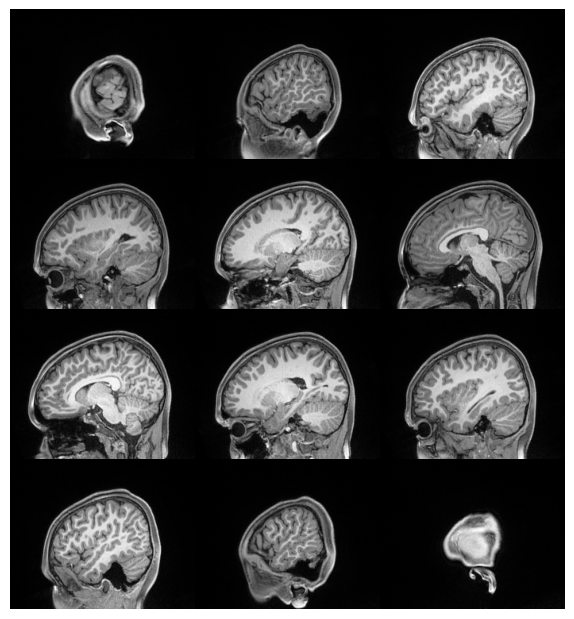

In [14]:
t1_img.plot()

#### Grabbing VSA* - Adds post-covid scans to list

In [4]:
import glob,os,re
R = re.compile(r"stx_(\d*)_VSA_*")

procd_paths = glob.glob("/DATA/Users/amahmood/braintyp/processed_v2/IBIS*.nii.gz")
len(procd_paths)

326

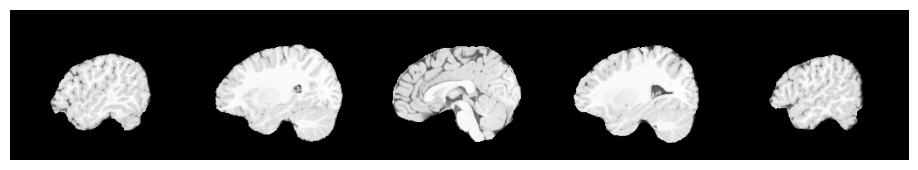

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (182, 218, 182)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-188.0, -224.0, 4.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [5]:
import ants

t1_img, t2_img = ants.image_read(procd_paths[0]).split_channels()
t1_img.plot(nslices=5)
t1_img

In [19]:
R = re.compile(r"(\d*).nii.gz")
_fn = lambda x: int(R.search(x).group(1))
subject_ids = set(map(_fn, procd_paths))
len(subject_ids)

326

In [20]:
inliers.head()

2     108372
3     113320
4     114640
6     119906
11    136262
Name: CandID, dtype: int64

In [21]:
on_disk = inliers.isin(subject_ids)
on_disk

2       True
3      False
4       True
6       True
11      True
       ...  
315    False
318     True
323    False
325     True
335    False
Name: CandID, Length: 99, dtype: bool

In [22]:
inlier_keys = inliers[on_disk]
inlier_keys.shape

(62,)

In [23]:
outlier_keys = outliers[outliers.isin(subject_ids)]
outlier_keys.shape

(36,)

In [26]:
ds_control_keys = pd.read_csv("ds-sa_inlier_keys.txt", header=None).astype(np.int64)
ds_control_keys

,0
0,114640
1,119906
2,171870
3,180215
4,186588
...,...
73,631202
74,656320
75,728124
76,778775


In [29]:
ibis_inlier_keys = pd.concat([inlier_keys, ds_control_keys]).drop_duplicates()
ibis_inlier_keys.shape

(86, 1)

In [30]:
ibis_inlier_keys.to_csv("ibis_inlier_keys.txt", header=None, index=None)
outlier_keys.to_csv("ibis_asd_keys.txt", header=None, index=None)